## Probing Language Model Relatedness Representations for Ambiguous (Spanish) Nouns

Here, we'll load the dataframe of BETO cosine distance results computed within the notebook `step0_get-cosine-distances`. Our goal here is to identify where in the modeling scheme the ambiguous nouns' embeddings begin to diverge for sentence pairs that evoke distinct senses of the target noun. 

We'll take a classification approach as well as an approach described by [Tenney et al. (2019)](https://arxiv.org/abs/1905.05950) to find the BETO layer at which target nouns' embeddings achieve the best *earliest* separation for different senses (termed: expected layer). 



In [1]:
%reset
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

import functools
import itertools
import os
import torch
import transformers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import statsmodels.formula.api as smf


from scipy.spatial.distance import cosine
from tqdm.notebook import tqdm
from transformers import AutoTokenizer


sns.set(style='whitegrid',font_scale=1.2)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### load your dataframe of model cosine distances 

In [3]:
datapath = "../data/processed/model/"
filename = "sawc_distances.csv"
df_model = pd.read_csv(os.path.join(datapath,filename))



### Grab the number of model layers
n_layers = df_model["Layer"].max()

Below, we briefly check to see whether the sentence pairs correspond to minimal pairs for the model (e.g. differ by a single disambiguating ***token***), in which case there should be no differences in the number of tokens across sentence pairs. This isn't necessarily guaranteed, since we optimized for **human** readability rather than token parity when creating the stimuli, so we just want to see what the distribution of token differences looks like. 

Text(0.5, 1.0, 'differences in tokenization for sentence pairs')

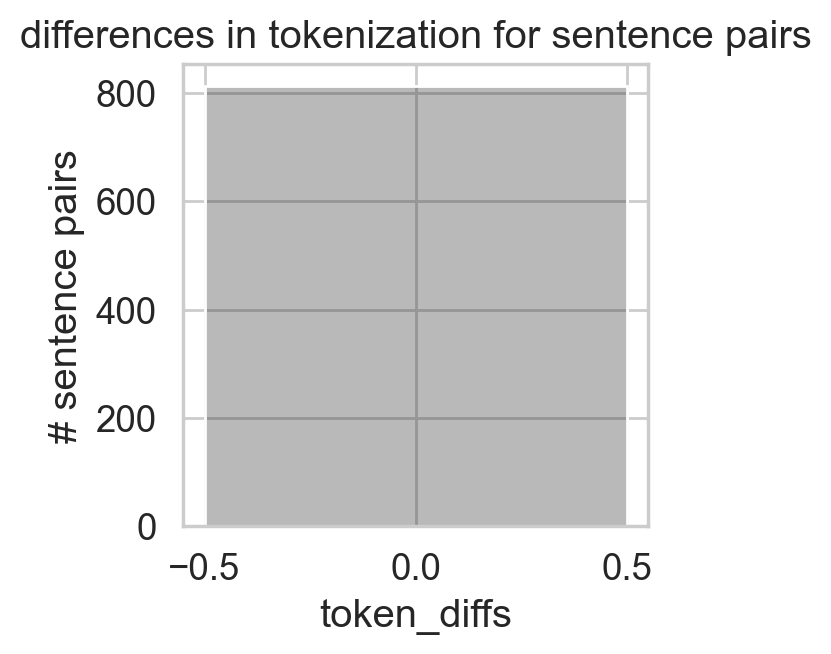

In [4]:
### Assess differences in token length for target words across the 
#.  sentence pairs

layer = 0
subset = df_model[df_model["Layer"] == layer]

fig,ax = plt.subplots(figsize=(3,3))

sns.histplot(data=subset,
             x='token_diffs',
             color='k',
             alpha=0.3)
plt.ylabel('# sentence pairs')
plt.title('differences in tokenization for sentence pairs')

In case of any non-zero token differences, we ask: does the difference in number of tokens representing each sentence correlate with the cosine distance between the target word embeddings derived from each sentence? We wouldn't want it to just be number of token differences across pairs driving any differences in the model's embeddings for the ambiguous word. 

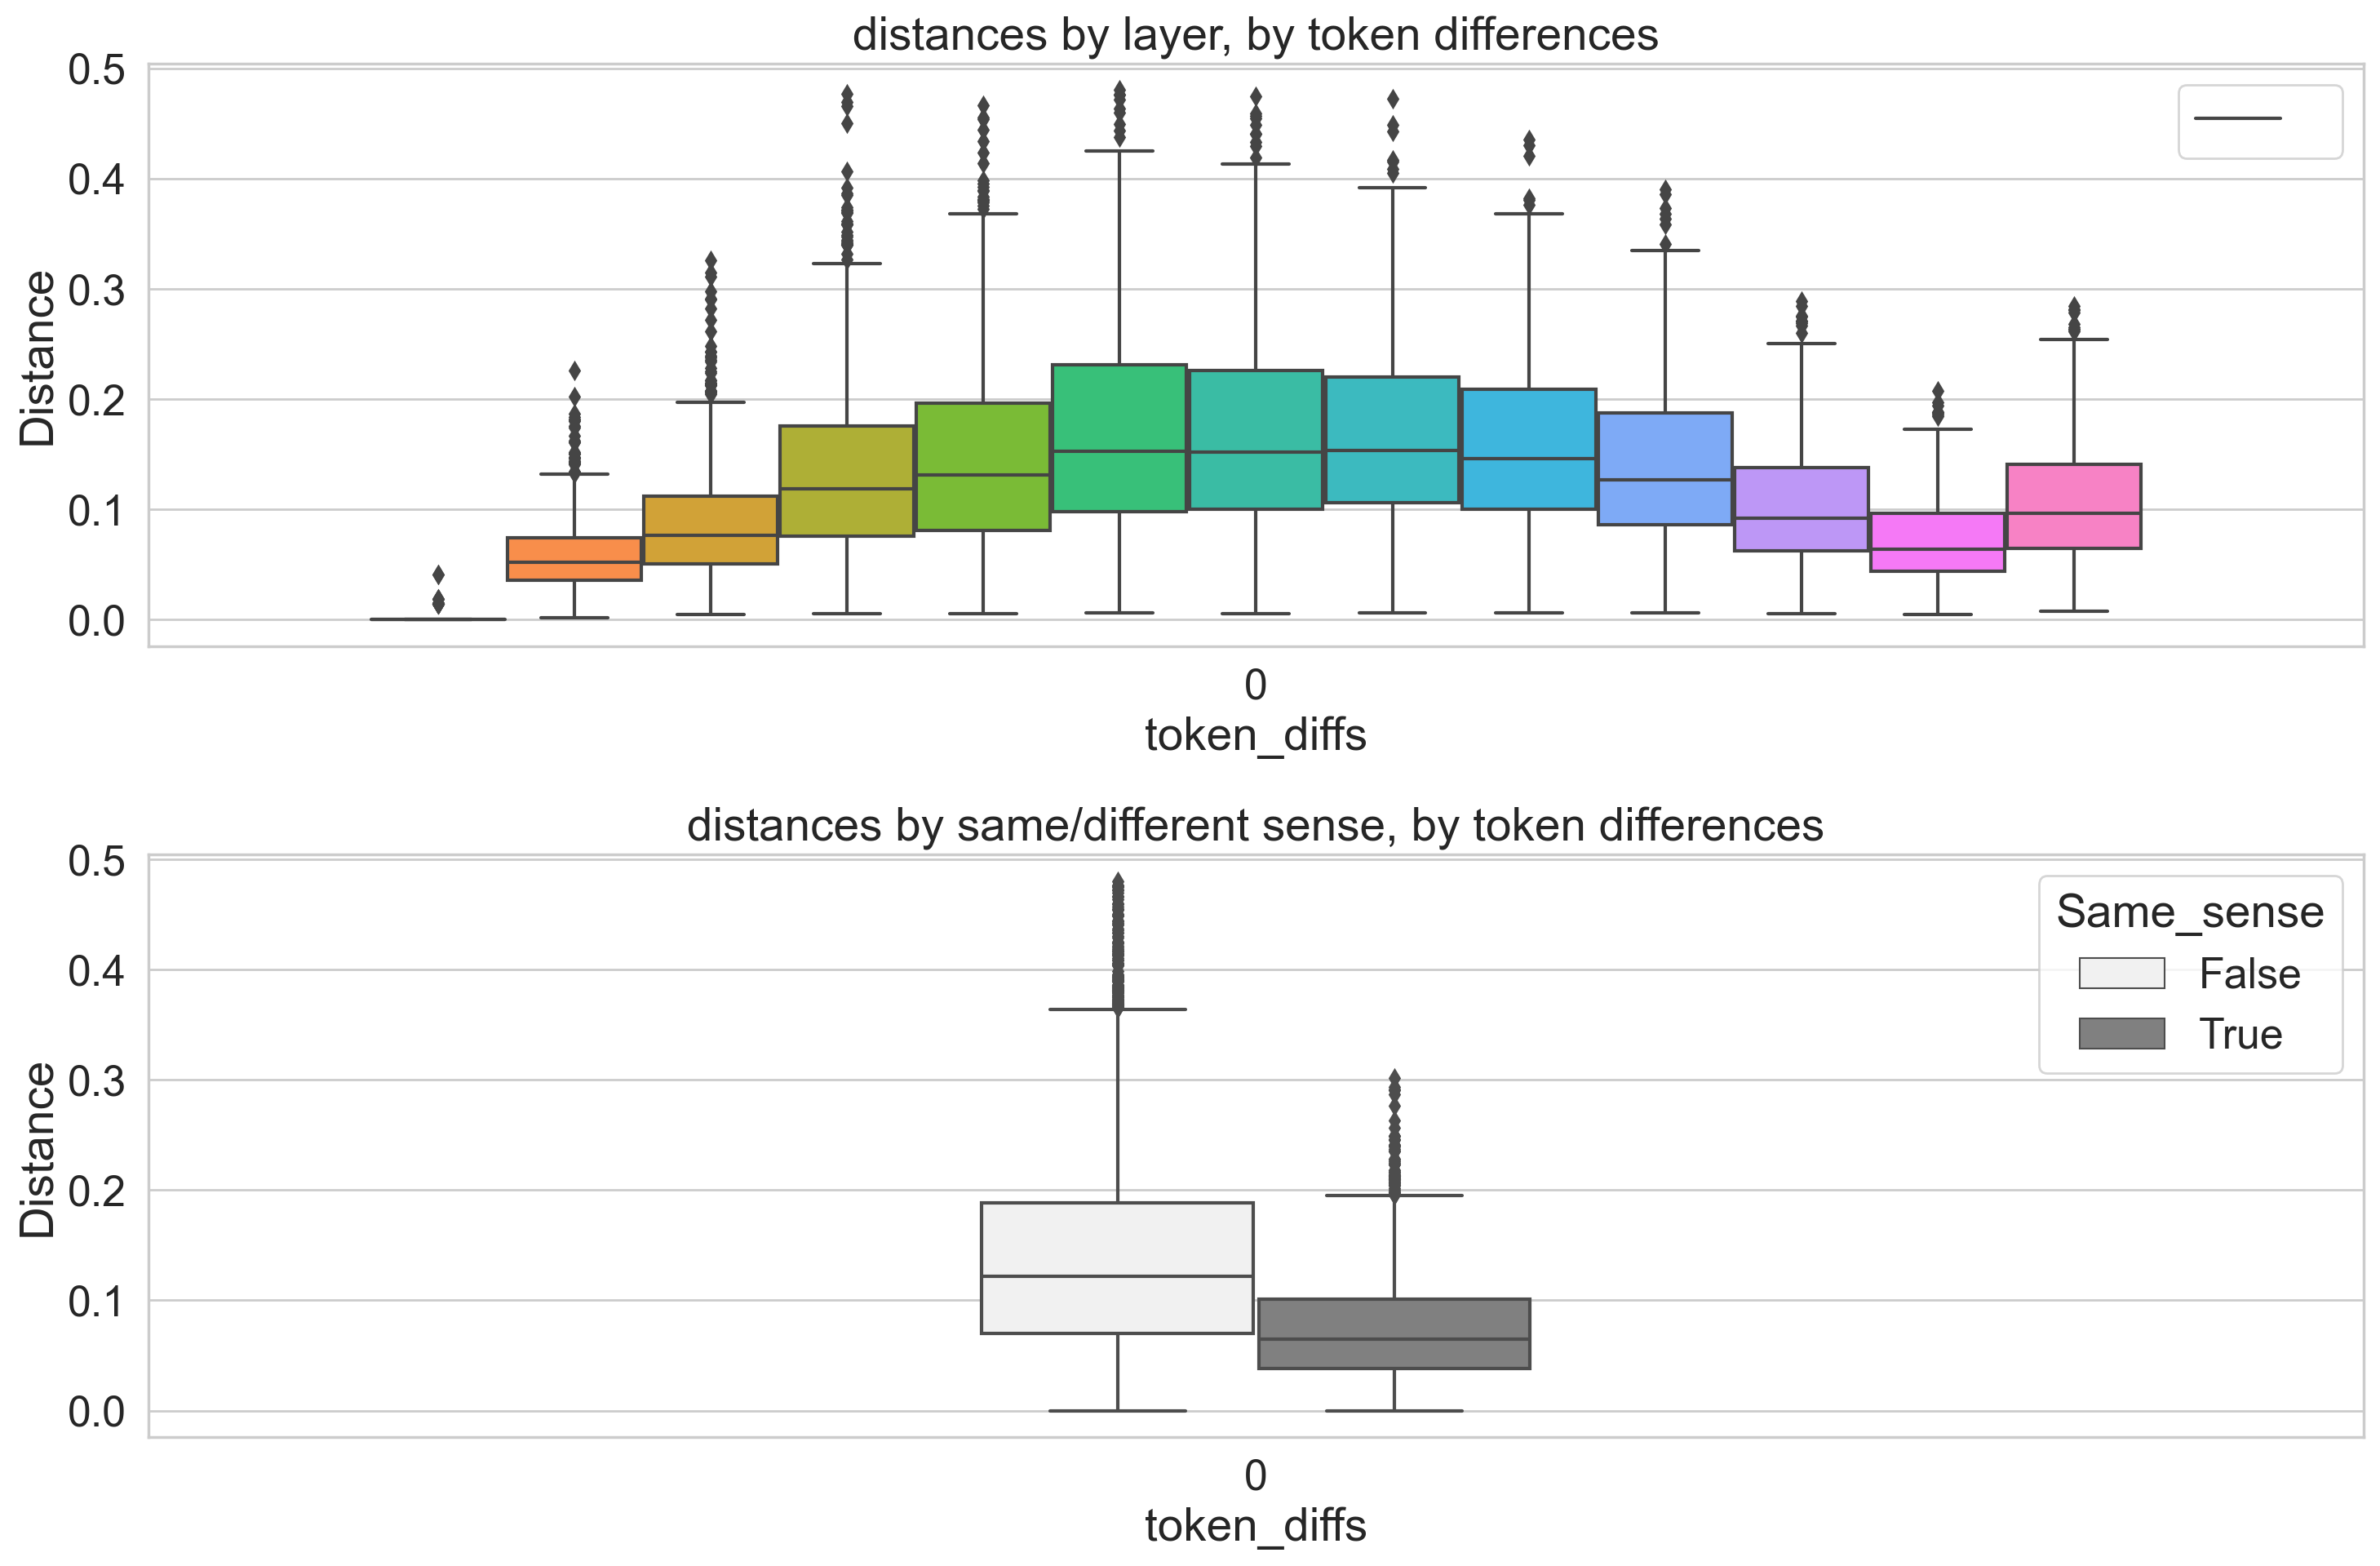

In [5]:
sns.set(style='whitegrid',font_scale=1.7)
fig, ax = plt.subplots(2,1,figsize=(15,10))

sns.boxplot(data=df_model,
            x='token_diffs',
            y='Distance',
            hue='Layer',
            saturation=1,
            ax=ax[0]
           ).set_title("distances by layer, by token differences")

ax[0].legend(' ')

sns.boxplot(data=df_model,
            x='token_diffs',
            y='Distance',
            color='grey',
            saturation=1,
            width=0.25,
            hue='Same_sense',
            ax=ax[1]
           ).set_title("distances by same/different sense, by token differences")

fig.tight_layout()

### plot cosine distances by model layer

splitting the data by same versus different sense

Text(0.5, 1.0, 'cosine distances \n n_wordforms = 102')

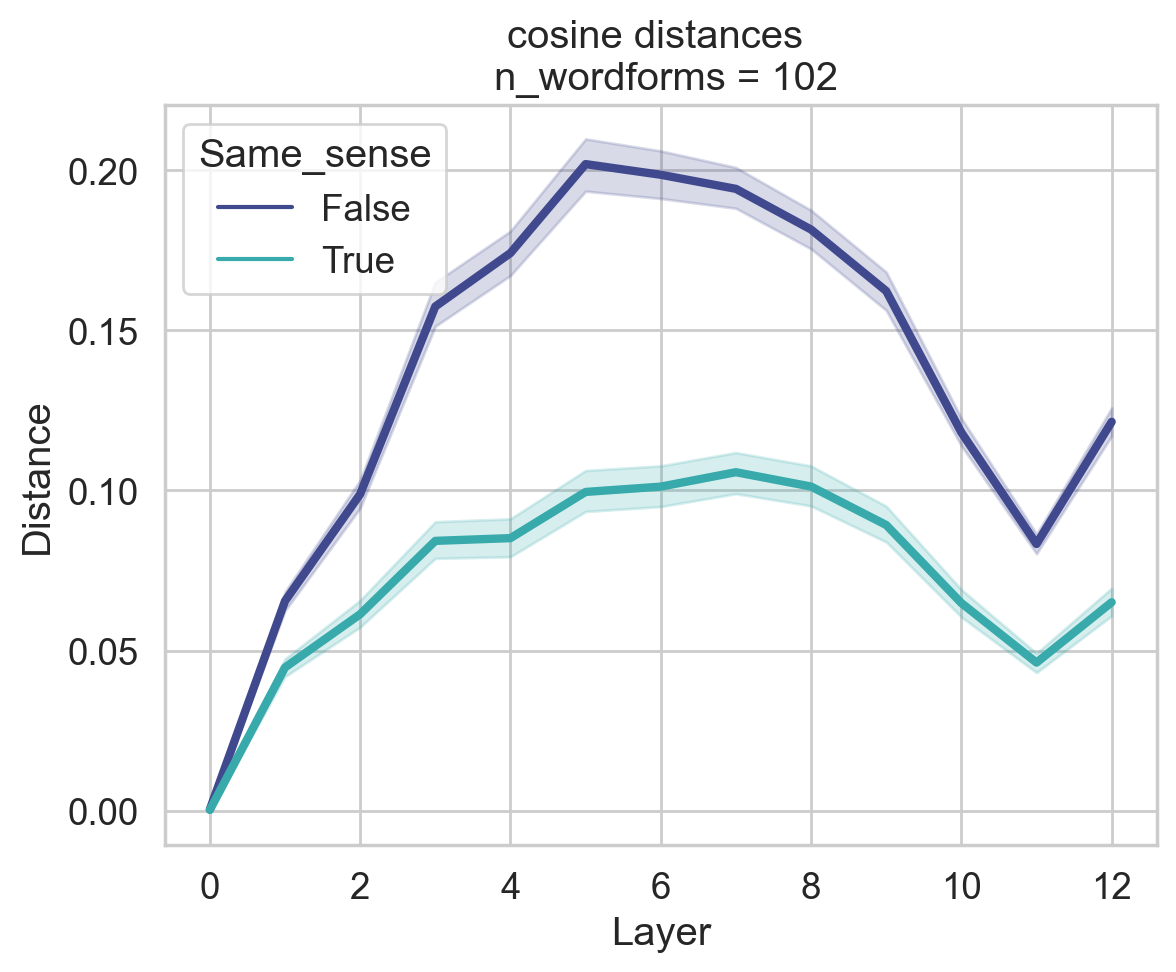

In [6]:
sns.set(style='whitegrid',font_scale=1.2)

n_wordforms = len(set(df_model["Word"]))


#visualize cosine distances layer by layer
sns.lineplot(data=df_model,
             x='Layer',
             y='Distance',
             hue='Same_sense',
             palette="mako",
             linewidth=3
            )

# uncomment below to plot the distances for a single word
# if you're interested in seeing how any given word is 
# represented differently across all sentence pairs evaluated,
# and how its cosine distances stack up against the distributions
# for same v. different sense

# target = 'título'
# sub = df_results[df_model['Word']==target]
# g = sns.scatterplot(data=sub,
#                     x='Layer',
#                     y='Distance',
#                     hue="Same_sense",
#                     palette=['navy','palevioletred'],
#                     alpha=0.3
#                    )

# sns.move_legend(g,'upper left',bbox_to_anchor=(1,1))


plt.title('cosine distances \n n_wordforms = '+str(n_wordforms))

## Do model cosine distances reflect human relatedness judgments?

### load your dataframe of human relatedness judgments

and merge these with the model cosine distances

In [8]:
datapath = "../data/processed/human"
filename = "sawc_avg_relatedness.csv" #"sawc_relatedness_full_critical_data.csv"

df_human = pd.read_csv(os.path.join(datapath,filename))


### Merge the dataframes containing model-based 
#   cosine distances (`df_model`) with the 
#.  dataframe containing human relatedness judg-
#.  ments (`df_human`)
df_merged = pd.merge(df_model, df_human, on="Word")

In [9]:
corr_results = []
for layer in range(n_layers+1):
    

    df_tmp = df_merged[df_merged['Layer']==layer]
    
    mod = smf.ols(data = df_tmp, formula = "Response ~ Distance").fit()
    
    r = ss.pearsonr(df_tmp['Distance'], df_tmp['Response'])
    
    corr_results.append({
        'rsquared': mod.rsquared,
        'layer': layer
    })
    
df_corr_results = pd.DataFrame(corr_results)

In [10]:
df_corr_results

,rsquared,layer
0,0.001560,0
1,0.003586,1
2,0.003250,2
3,0.004196,3
4,0.005378,4
5,0.005837,5
6,0.005634,6
7,0.006363,7
8,0.006191,8
9,0.006593,9


<AxesSubplot:xlabel='layer', ylabel='rsquared'>

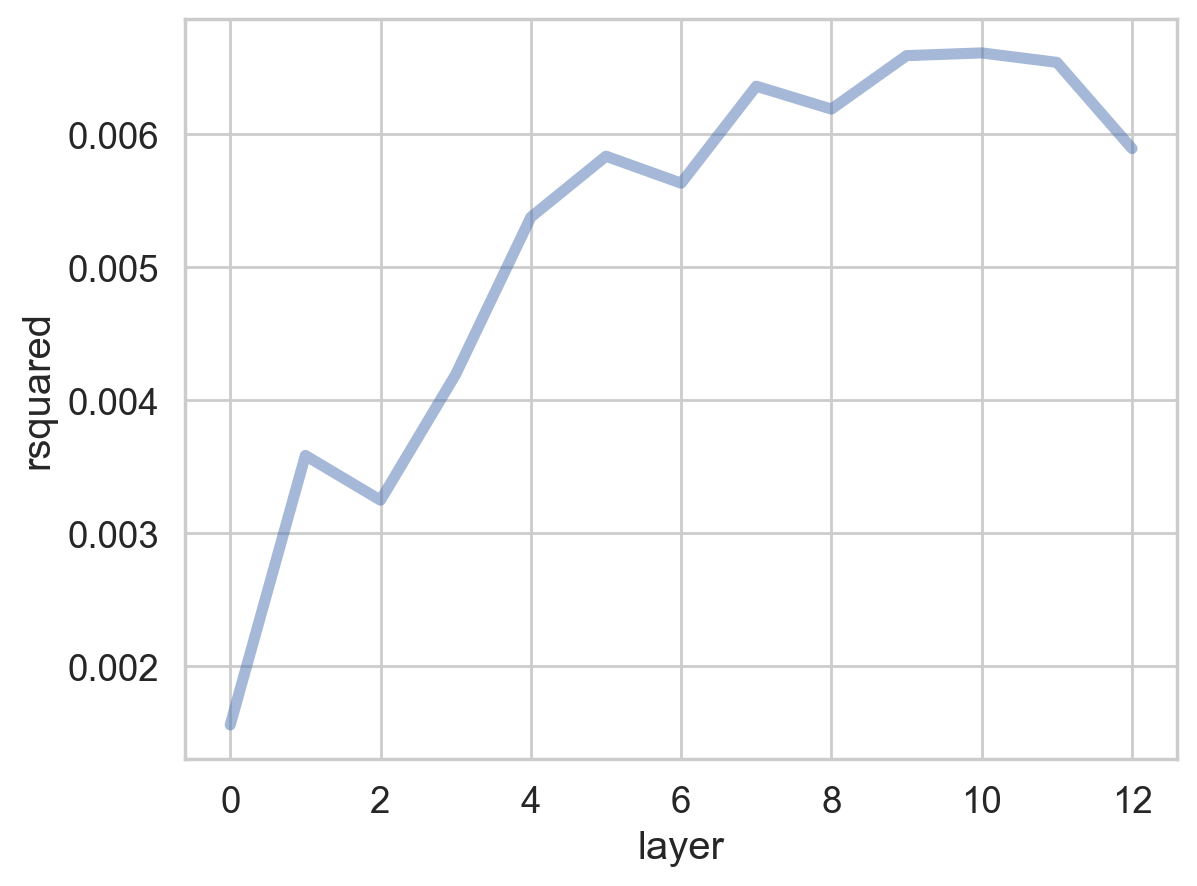

In [11]:
sns.lineplot(data = df_corr_results,
             x = "layer", 
             y = "rsquared",
             palette='mako',
             linewidth=4,
             alpha=0.5)

#### Implementing Tenney et al. (2019) approach

Expected layer calculation:

$\Large \bar{E}_\Delta[\ell] = \frac{\sum_{\ell=1}^L\ell*\Delta_T^{\ell}}{\sum_{\ell=1}^L\Delta_T^{\ell}}$

Where:

$\Delta_T^{\ell_i} = Score(\ell_i) - Score(\ell_{i-1})$

In [12]:
### First, calculate difference in R^2 between each subsequent layer
df_corr_results['delta'] = df_corr_results['rsquared'].diff()

In [13]:
### Now, calculate "expected layer"
num = (df_corr_results['layer'] * df_corr_results['delta']).sum()
denom = df_corr_results['delta'].sum()

e = num/denom
e

2.073578710163872

### classifier

In [14]:
#### Sean testing
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import svm,linear_model
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score

# logreg = linear_model.LogisticRegression()

logreg = linear_model.LogisticRegression(class_weight = "balanced")

In [29]:
classifier_results = []

for layer in range(n_layers+1):
    
    df_tmp = df_model[df_model['Layer'] == layer]
    
    X = df_tmp['Distance'].values
    y = df_tmp['Same_sense'].values
    
    y_pred = cross_val_predict(logreg,
                               X.reshape(-1,1),
                               y.ravel(),
                               # method='predict_proba',
                               cv = 10)
    
    # ll = log_loss(y, probs)
    accuracy = accuracy_score(y, y_pred)
    
    classifier_results.append({
        'layer': layer,
        'accuracy': accuracy
    })
    
df_classifier_results = pd.DataFrame(classifier_results)
df_classifier_results

,layer,accuracy
0,0,0.311576
1,1,0.603448
2,2,0.633005
3,3,0.666256
4,4,0.713054
5,5,0.720443
6,6,0.711823
7,7,0.711823
8,8,0.700739
9,9,0.699507


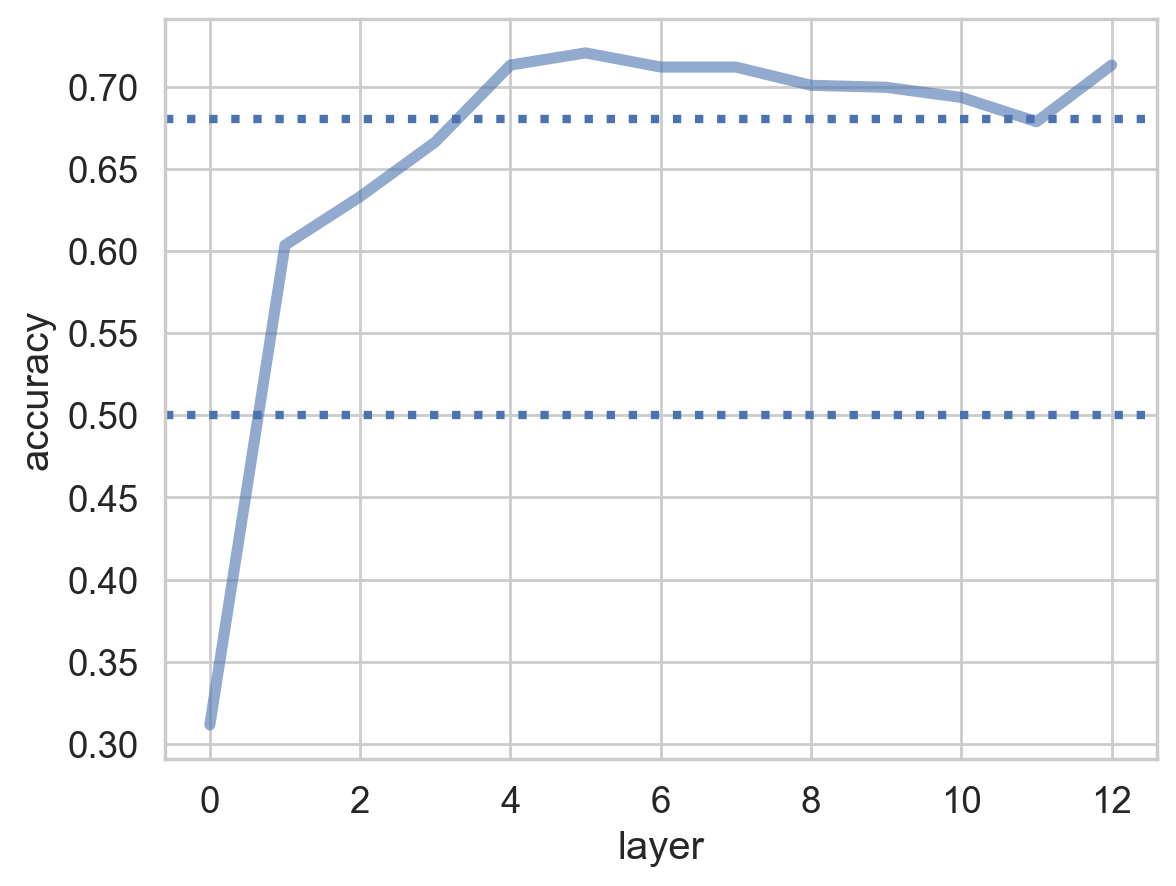

In [28]:
sns.lineplot(data = df_classifier_results, 
             x = "layer", 
             y = "accuracy",
             linewidth=4,
             palette="mako",
             alpha=0.6
            )

# plt.axhline(y = baseline_5050, linestyle = "dotted")
# plt.axhline(y = baseline_majority, linestyle = "dotted")

plt.axhline(y = .5, linestyle = "dotted",linewidth=3)
plt.axhline(y = .68, linestyle = "dotted",linewidth=3)

#### Trying to implement Tenney et al. (2019)

Tenney et al. (2019) do this as follows: 

$\bar{E}_\Delta[\ell] = \frac{\sum_{\ell=1}^L\ell\cdot\Delta_T^{\ell}}{\sum_{\ell=1}^L\Delta_T^{\ell}}$

Where:

$\Delta_T^{\ell_i} = Score(\ell_i) - Score(\ell_{i-1})$

In [30]:
### First, calculate difference in log loss between each subsequent layer
df_classifier_results['delta'] = df_classifier_results['accuracy'].diff()

In [31]:
### Now, calculate "expected layer"
num = (df_classifier_results['layer'] * df_classifier_results['delta']).sum()
denom = df_classifier_results['delta'].sum()

e = num/denom
e

1.7760736196319018